# Bayesian optimization (BO) - find the minimum value of 2 variable function
Reference: <br>
https://datachemeng.com/bayesianoptimization/ <br>
http://krasserm.github.io/2018/03/21/bayesian-optimization/ <br>
https://orbi.uliege.be/bitstream/2268/226433/1/PyData%202017_%20Bayesian%20optimization%20with%20Scikit-Optimize.pdf <br>
https://github.com/Ma-sa-ue/practice/blob/master/machine%20learning(python)/bayeisan_optimization.ipynb

### Prepare sample data

In [1]:
#!pip install GPy GPyOpt

In [2]:
%pylab inline  
import numpy as np
import pandas as pd
import GPy
import GPyOpt
from numpy.random import seed
import matplotlib
import IPython
from IPython.display import clear_output
from PIL import Image
import mpl_toolkits.mplot3d
import time
from apng import APNG
import glob
import os

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Definition of a black-box function to understand the concept
def f_y(X) :
    x1 = X.iloc[:, 0]
    x2 = X.iloc[:, 1]
    y = np.cos(x1) + np.cos(x2) + x1 / 10.0
    return y

In [4]:
# Draw black-box function
np.random.seed(seed = 5)
df_y = pd.DataFrame()
X = np.random.rand(5000, 2) * 10.0
df_y['x1'] = X[:, 0]
df_y['x2'] = X[:, 1]
df_y['y'] = f_y(df_y)

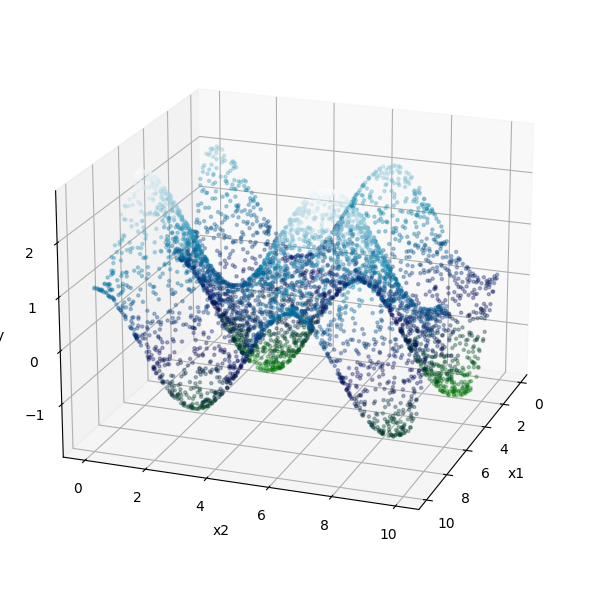

In [5]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
ax.scatter(df_y['x1'], df_y['x2'], df_y['y'], c = df_y['y'], cmap = 'ocean', alpha = 0.3, s = 5)

ax.view_init(elev = 20, azim = 20)

plt.tight_layout()
plt.show()

In [6]:
# Check x1, x2, y at the minimum y position

df_y.to_csv('sample_model.csv', index = False)
df = pd.read_csv('sample_model.csv')

max_y = argmax(df_y['y'])
min_y = argmin(df_y['y'])

print('The min place x1 = ', df_y['x1'][min_y])
print('The min place x2 = ', df_y['x2'][min_y])
print('The min place y  = ', df_y['y'][min_y])

The min place x1 =  3.0530125552610556
The min place x2 =  9.408379749076
The min place y  =  -1.6906436445043362


In [7]:
# Random x generation
init_exp_num = 15

random.seed(111)
rnd_idx_initial = [random.randint(0, len(df_y)) for i in range(init_exp_num)]
print(rnd_idx_initial)

[3924, 2004, 4820, 4182, 681, 4214, 2856, 953, 3338, 1473, 1904, 728, 2466, 1045, 2760]


In [8]:
# The initial dataframe of x, y 
df_y_initial = df_y.loc[rnd_idx_initial]

# Determine explanatory variables X and target variable y
df_X_train = df_y_initial.iloc[:, 0:2]
df_y_train = df_y_initial.iloc[:, 2]

print(df_X_train.shape)
df_X_train.to_csv('sample_model_initial_X_train.csv', index = False)

print(df_y_train.shape)
df_y_train.to_csv('sample_model_initial_y_train.csv', index = False, header = 'y')

(15, 2)
(15,)


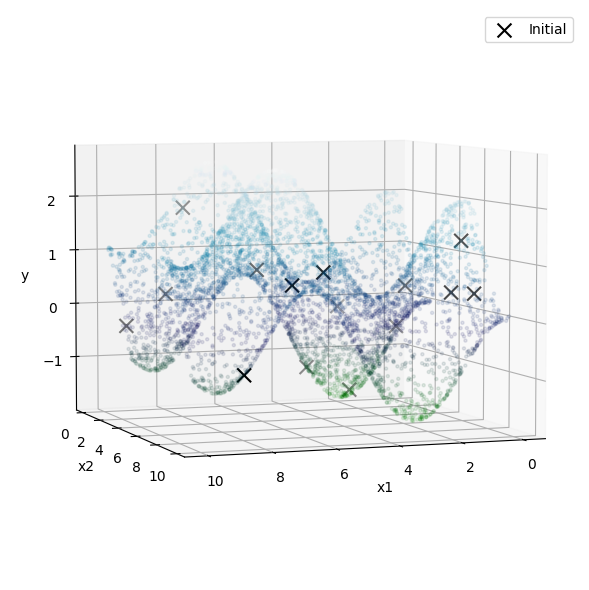

In [9]:
# Check the initial values
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
ax.scatter(df_y['x1'], df_y['x2'], df_y['y'], c = df_y['y'], cmap = 'ocean', alpha = 0.1, s = 5)
ax.scatter(df_y_initial['x1'], df_y_initial['x2'], df_y_initial['y'], c = 'k', marker = 'x', s=100, label = 'Initial')

ax.view_init(elev = 5, azim = 70)

plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [10]:
df_X_train_init = pd.read_csv('sample_model_initial_X_train.csv')
df_y_train_init = pd.read_csv('sample_model_initial_y_train.csv')

### Make GPR models

In [11]:
# dictionary of kernel
dim_num = 2
kernel_dict = {1:GPy.kern.RBF(input_dim = dim_num),
               2:GPy.kern.RBF(input_dim = dim_num) + GPy.kern.Bias(input_dim = dim_num),
               3:GPy.kern.RBF(input_dim = dim_num) + GPy.kern.Bias(input_dim = dim_num) + GPy.kern.Linear(input_dim = dim_num),
               4:GPy.kern.Matern32(input_dim = dim_num) * GPy.kern.RBF(input_dim = dim_num),
               5:GPy.kern.Matern52(input_dim = dim_num) * GPy.kern.RBF(input_dim = dim_num),
               6:GPy.kern.Exponential(input_dim = dim_num),
               7:GPy.kern.Exponential(input_dim = dim_num) * GPy.kern.RBF(input_dim = dim_num) + GPy.kern.White(input_dim = dim_num)}

In [12]:
def MakeModel(X, y, kern):
    X = np.array(X)
    y = np.array(y).reshape(-1, 1)
    model = GPy.models.GPRegression(X, y, kernel = kern)
    model.optimize()
    
    return model

### GPR model for the initial experiment points

In [13]:
r2_list = []
rmse_list = []

for i in kernel_dict.keys() :
    kern = kernel_dict[i]
    
    model_selec_kerm = MakeModel(df_y_initial.iloc[:, 0:2], df_y_initial.iloc[:, 2], kernel_dict[i])

    X_score = np.array(df_y_initial.iloc[:, 0:2])
    y_score = np.array(df_y_initial.iloc[:, 2])
    y_pred = model_selec_kerm.predict(X_score)[0]
    r2 = r2_score(y_score, y_pred)
    rmse = np.sqrt(mean_squared_error(y_score, y_pred))

    r2_list.append(r2)
    rmse_list.append(rmse)

max_r2_idx = argmax(r2_list)
min_rmse_idx = argmin(rmse_list)

print('Best kernel = ', max_r2_idx)

Best kernel =  6


In [14]:
# The initial fitted surface
initial_surface = MakeModel(df_y_initial.iloc[:, 0:2], df_y_initial.iloc[:, 2], kernel_dict[max_r2_idx])

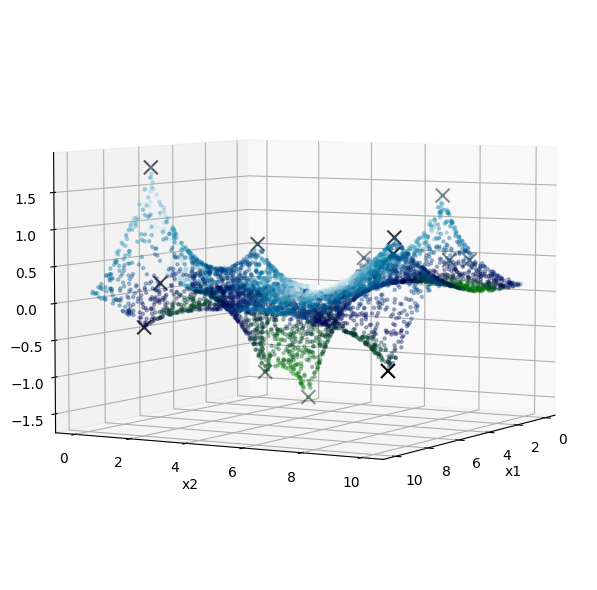

In [15]:
np.random.seed(seed = 5)
df_y_init = pd.DataFrame()
X_init = np.random.rand(5000, 2) * 6.0 - 3.0
df_y_init['x1'] = X[:, 0]
df_y_init['x2'] = X[:, 1]
df_y_init['y'] = initial_surface.predict(X)[0]

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
ax.scatter(df_y_init['x1'], df_y_init['x2'], df_y_init['y'], c = df_y['y'], cmap = 'ocean', alpha = 0.3, s = 5)
ax.scatter(df_y_initial['x1'], df_y_initial['x2'], df_y_initial['y'], c = 'k', marker = 'x', s=100, label = 'Initial')

ax.view_init(elev = 5, azim = 30)

plt.tight_layout()
plt.show()

In [16]:
# Check the minimum place and value
max_y = argmax(df_y_init['y'])
min_y = argmin(df_y_init['y'])

print('The min place x1 = ', df_y_init['x1'][min_y])
print('The min place x2 = ', df_y_init['x2'][min_y])
print('The min place y  = ', df_y_init['y'][min_y])

The min place x1 =  2.9583498680524767
The min place x2 =  3.734761463934473
The min place y  =  -1.5165963337294441


### GPR model for the initial experiment points

In [17]:
r2_list = []
rmse_list = []

for i in kernel_dict.keys() :
    kern = kernel_dict[i]
    
    model_selec_kerm = MakeModel(df_X_train_init, df_y_train_init, kern)

    X_score = np.array(df_X_train_init)
    y_score = np.array(df_y_train_init)
    y_pred = model_selec_kerm.predict(X_score)[0]
    r2 = r2_score(y_score, y_pred)
    rmse = np.sqrt(mean_squared_error(y_score, y_pred))

    r2_list.append(r2)
    rmse_list.append(rmse)

In [18]:
max_r2_idx = argmax(r2_list)
min_rmse_idx = argmin(rmse_list)

print('Best kernel = ', max_r2_idx)
print('The best model for the initial samples is made.')

Best kernel =  5
The best model for the initial samples is made.


### Bayesian optimization : one iteration at the maximum aquisition function 

In [19]:
# Bounds : the range of variables
bounds = [
    {'name': 'x1',
     'type': 'continuous',
     'domain': (0.0, 10.0)},
    
    {'name': 'x2',
     'type': 'continuous',
     'domain': (0.0, 10.0)}
]

# Iteration to find the next point
BO_sampling_iter = 1 

### First sampling

In [20]:
feature_x = ['x1', 'x2']
feature_y = ['y']

In [21]:
best_loop_model = MakeModel(df_X_train_init, df_y_train_init, kernel_dict[max_r2_idx])

In [22]:
# The function that want to mimimize (or maximize by multiplied by -1)

def my_f(X):
    y = best_loop_model.predict(X)[0]   # return only the mean value
    return y

In [23]:
# Bayesian optimization for DOE

myProblem = GPyOpt.methods.BayesianOptimization(my_f, bounds)
myProblem.run_optimization(BO_sampling_iter)
    
X_sample_next = myProblem.x_opt

X_sample_next

array([2.80113877, 4.01963205])

In [24]:
df_X_sample_next = pd.DataFrame(X_sample_next).T
df_X_sample_next.columns = feature_x
df_X_train_next = pd.concat([df_X_train_init, df_X_sample_next], axis = 0)

In [25]:
df_y_sample_next = pd.DataFrame(f_y(df_X_sample_next))
df_y_sample_next.columns = feature_y

In [26]:
df_y_train_next = pd.concat([df_y_train_init, df_y_sample_next])
print(df_y_train_next.shape)

(16, 1)


### Adaptive DOE stage from here

In [27]:
def UpdateModel(X, y, latest_best_idx):
    #print('Latest index of the best model = ', latest_best_idx)
    
    X = np.array(X)
    y = np.array(y).reshape(-1, 1)
    model = GPy.models.GPRegression(X, y, kernel = kernel_dict[latest_best_idx])
    model.optimize()
       
    return model

In [28]:
def SelectBestModelIndex(X, y, latest_best_idx):
    r2_list = list()
    rmse_list = list()

    for i in kernel_dict.keys() :
        kern = kernel_dict[i]

        model_selec_loop = UpdateModel(X, y, i)

        X_score = np.array(X)
        y_score = np.array(y)
        y_pred = model_selec_loop.predict(X_score)[0]
        r2 = r2_score(y_score, y_pred)
        rmse = np.sqrt(mean_squared_error(y_score, y_pred))

        r2_list.append(r2)
        rmse_list.append(rmse)
        
        latest_max_r2_idx = argmax(r2_list) + 1
        
    return latest_max_r2_idx

In [29]:
# The function that want to mimimize (or maximize by multiplied by -1)

def my_f_update(X):
    y = updated_model.predict(X)[0]   # return only the mean value
    return y

In [30]:
#!pip install APNG

In [31]:
filenames = []
os.makedirs('fig_folder', exist_ok = True)

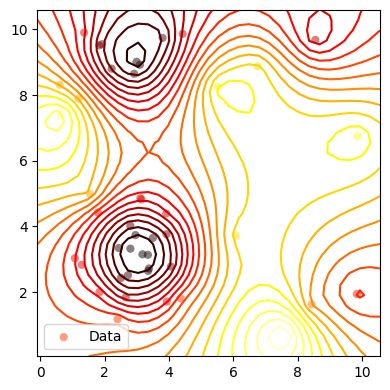

In [32]:
# Interation for BO
iter_BO = 30

best_idx_next = max_r2_idx
plt.figure(figsize(4, 4))

for i in range(iter_BO):
    #print('Iteration = ', i+1, '       Best model index = ', best_idx_next)
    
    best_idx_next = SelectBestModelIndex(df_X_train_next, df_y_train_next, best_idx_next)
    updated_model = UpdateModel(df_X_train_next, df_y_train_next, best_idx_next)
    
    myProblem = GPyOpt.methods.BayesianOptimization(my_f_update, bounds)
    myProblem.run_optimization(BO_sampling_iter)
    
    X_sample_next = myProblem.x_opt
    y_sample_next = f_y(df_X_sample_next)
    
    df_X_sample_next = pd.DataFrame(X_sample_next).T
    df_X_sample_next.columns = feature_x
    df_y_sample_next = pd.DataFrame(f_y(df_X_sample_next))
    df_y_sample_next.columns = feature_y
    
    df_X_train_next = pd.concat([df_X_train_next, df_X_sample_next], axis = 0)
    df_y_train_next = pd.concat([df_y_train_next, df_y_sample_next])
    
    clear_output(True)
    updated_model.plot()
    plt.savefig('fig_folder/fig_model_{:04}.png'.format(i))
    filename = 'fig_folder/fig_model_{:04}.png'.format(i)
    filenames.append(filename)
    
    plt.show()

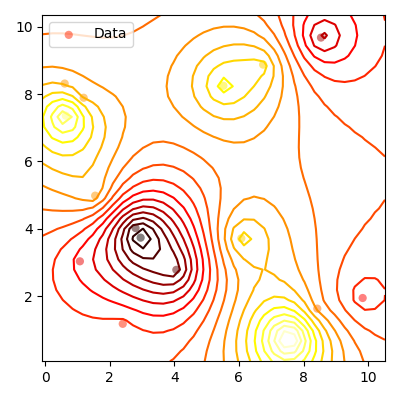

In [33]:
APNG.from_files(filenames, delay = 200).save('fig_folder/fig_animayion.png')
IPython.display.Image('fig_folder/fig_animayion.png')

In [34]:
files = glob.glob('fig_folder/*.png')
    
images = list(map(lambda file : Image.open(file), files))
images[0].save('fig_folder/animation_2.gif', save_all = True, append_images = images[1:], optimize = True, duration = 100 , loop = 1)

In [35]:
df_y_last = pd.DataFrame()
df_y_last['x1'] = X[:, 0]
df_y_last['x2'] = X[:, 1]
df_y_last['y'] = updated_model.predict(X)[0]

In [36]:
max_y_last = argmax(df_y_last['y'])
min_y_last = argmin(df_y_last['y'])

print('The min place x1 = ', df_y_last['x1'][min_y_last])
print('The min place x2 = ', df_y_last['x2'][min_y_last])
print('The min place y  = ', df_y_last['y'][min_y_last])

The min place x1 =  3.017781886456854
The min place x2 =  3.1700828004835566
The min place y  =  -1.6810015220381966


In [37]:
df_X_train_sampling = df_X_train_next.iloc[init_exp_num : init_exp_num + iter_BO, :]
df_y_train_sampling = df_y_train_next.iloc[init_exp_num : init_exp_num + iter_BO, :]

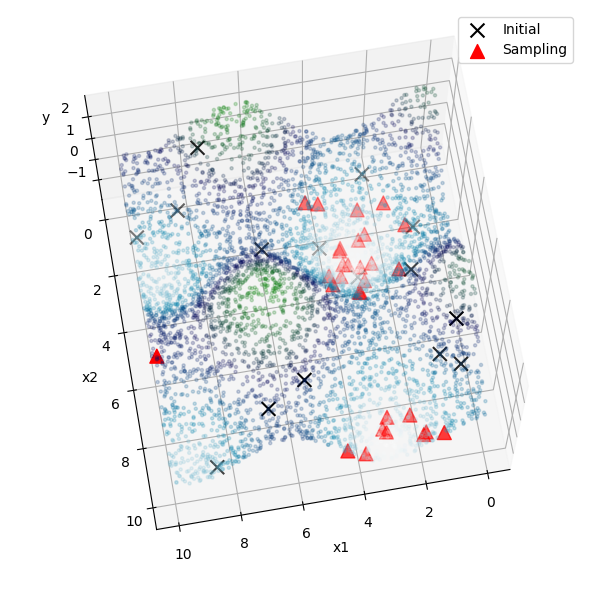

In [38]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
ax.scatter(df_y['x1'], df_y['x2'], df_y['y'], c = -df_y['y'], cmap = 'ocean', alpha = 0.2, s = 5)
ax.scatter(df_y_initial['x1'], df_y_initial['x2'], df_y_initial['y'], c = 'k', marker = 'x', s=100, label = 'Initial')
ax.scatter(df_X_train_sampling['x1'], df_X_train_sampling['x2'], df_y_train_sampling['y'], c = 'r', marker = '^', s=100, label = 'Sampling')

ax.view_init(elev=70, azim=80)

plt.legend()
plt.tight_layout()
plt.show()

### Additional experiments finished, so finally find the minimum value by BO

In [39]:
updated_model = MakeModel(df_X_train_next, df_y_train_next, kern)

In [40]:
print(updated_model)


Name : GP regression
Objective : -63.93139564488064
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  GP_regression.                   |                   value  |  constraints  |  priors
  sum.mul.Exponential.variance     |       4.822012872025816  |      +ve      |        
  sum.mul.Exponential.lengthscale  |      262400.93327729526  |      +ve      |        
  sum.mul.rbf.variance             |      0.3677152229680849  |      +ve      |        
  sum.mul.rbf.lengthscale          |      2.3657499606043637  |      +ve      |        
  sum.white.variance               |  5.296420300461954e-104  |      +ve      |        
  Gaussian_noise.variance          |  3.4158244575351836e-14  |      +ve      |        


In [41]:
# The function that want to mimimize (or maximize by multiplied by -1)

def my_f_min(X):
    y = updated_model.predict(X)[0]   # return only the mean value
    return y

In [42]:
np.random.seed(777)
optimizer = GPyOpt.methods.BayesianOptimization(
    f = my_f_min,
    domain = bounds,
    acquisition_type ='MPI',
    acquisition_par = 0.1,
    exact_eval=True
)

optimizer.run_optimization(max_iter = 50)

In [43]:
print('The min place x1 = ', optimizer.x_opt[0])
print('The min place x2 = ', optimizer.x_opt[1])
print('The min place y  = ', optimizer.fx_opt)

The min place x1 =  3.058726157132653
The min place x2 =  9.44766450320191
The min place y  =  -1.6915090271122608


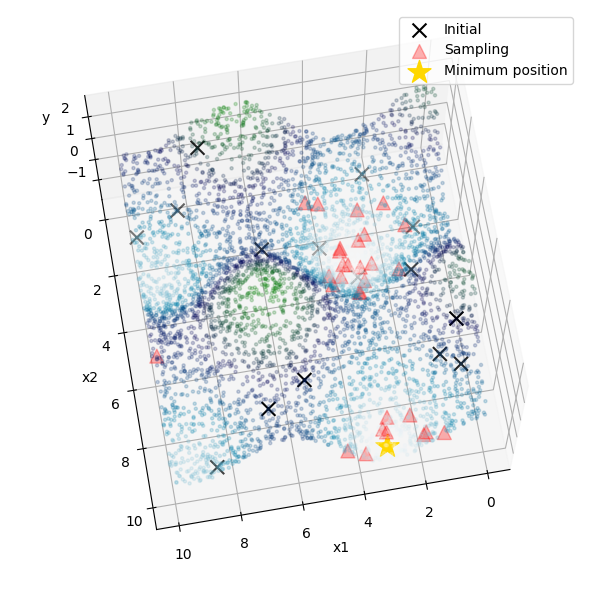

In [44]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
ax.scatter(df_y['x1'], df_y['x2'], df_y['y'], c = -df_y['y'], cmap = 'ocean', alpha = 0.2, s = 5)
ax.scatter(df_y_initial['x1'], df_y_initial['x2'], df_y_initial['y'], c = 'k', marker = 'x', s=100, label = 'Initial')
ax.scatter(df_X_train_sampling['x1'], df_X_train_sampling['x2'], df_y_train_sampling['y'], c = 'r', marker = '^', s=100, label = 'Sampling', alpha = 0.3)
ax.scatter(optimizer.x_opt[0], optimizer.x_opt[1], optimizer.fx_opt, c = 'gold', marker = '*', s=300, label = 'Minimum position')

ax.view_init(elev=70, azim=80)

plt.legend()
plt.tight_layout()
plt.show()

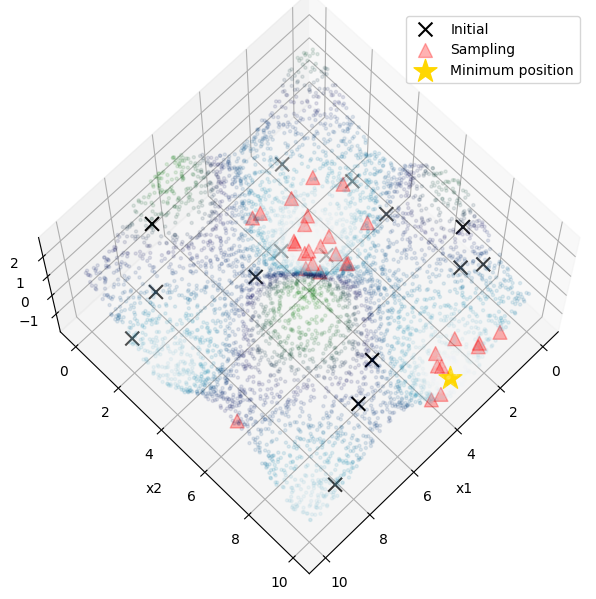

In [45]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
ax.scatter(df_y['x1'], df_y['x2'], df_y['y'], c = -df_y['y'], cmap = 'ocean', alpha = 0.1, s = 5)
ax.scatter(df_y_initial['x1'], df_y_initial['x2'], df_y_initial['y'], c = 'k', marker = 'x', s=100, label = 'Initial')
ax.scatter(df_X_train_sampling['x1'], df_X_train_sampling['x2'], df_y_train_sampling['y'], c = 'r', marker = '^', s=100, label = 'Sampling', alpha = 0.3)
ax.scatter(optimizer.x_opt[0], optimizer.x_opt[1], optimizer.fx_opt, c = 'gold', marker = '*', s=300, label = 'Minimum position')

ax.view_init(elev=70, azim=45)

plt.legend()
plt.tight_layout()
plt.show()

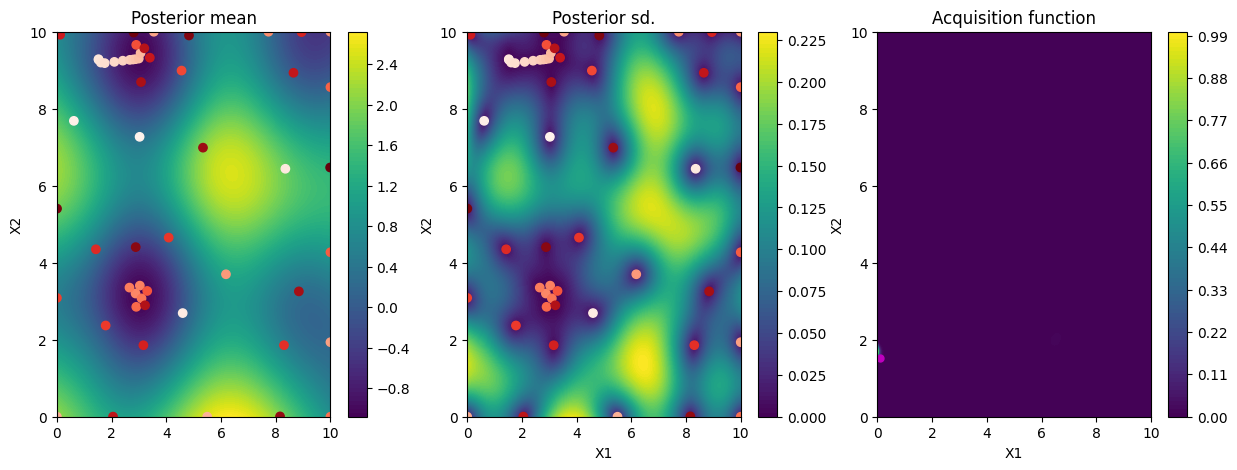

In [46]:
optimizer.plot_acquisition()

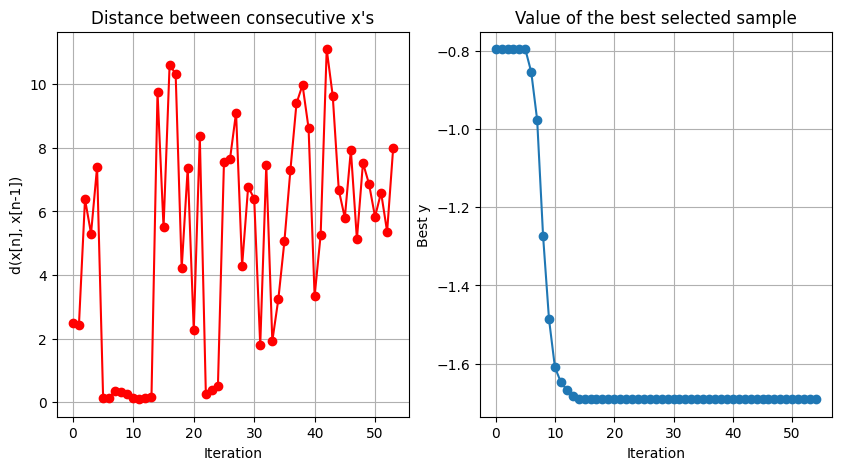

In [47]:
optimizer.plot_convergence()

### Fall into the local optima when the black-box function is complicated and number of experiments is too small.